In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx 
from matplotlib import pyplot as plt 
import numpy as np

Created 300 edges out of 300 possible edges
NOTICE: The nodes are strings, not integers.


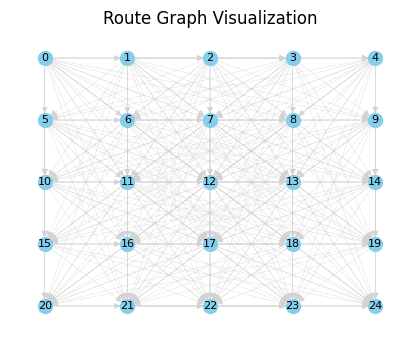

In [2]:
# Create a graph consisting of 25 nodes
# Create a graph with 25 nodes in a 5x5 grid
G = nx.DiGraph()

# Add nodes with attributes
for i in range(25):
    row = i // 5  # Integer division to get row (0-4)
    col = i % 5   # Modulo to get column (0-4)
    G.add_node(str(i), label=i, row=row, col=col, lat=row*0.1, lon=col*0.1)

# Add all possible edges between the 25 nodes (25C2 edges)
for i in range(25):
    for j in range(i+1, 25):  # Start from i+1 to avoid duplicates and self-loops
        # Calculate distance between nodes based on their grid positions
        node_i_row, node_i_col = G.nodes[str(i)]['row'], G.nodes[str(i)]['col']
        node_j_row, node_j_col = G.nodes[str(j)]['row'], G.nodes[str(j)]['col']
        
        # Euclidean distance as edge weight
        distance = np.sqrt((node_i_row - node_j_row)**2 + (node_i_col - node_j_col)**2)
        
        # Add edge with distance as weight
        G.add_edge(str(i), str(j), weight=distance, distance=distance)

# Print the number of edges to verify
print(f"Created {G.number_of_edges()} edges out of {25*24//2} possible edges")
print(f'NOTICE: The nodes are strings, not integers.')

# Visualize the graph
plt.figure(figsize=(4, 3))

# Get node positions from row and col attributes
pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, font_size=8, edge_color='lightgray', width=0.25)

# Draw edge weights (distances)
# edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Route Graph Visualization")
plt.axis('off')  # Turn off axis
plt.show()

In [3]:
import math
import random

def generate_routes(G, node_ori, node_dest):
    """
    Generate 5 different routes from origin to destination node in the graph.
    
    Args:
        G (networkx.Graph): The graph to search
        node_ori (int): Origin node ID
        node_dest (int): Destination node ID
        
    Returns:
        list: List of 5 different paths, where each path is a list of node IDs
    """
    routes = []
    
    # 1. Shortest path (using Dijkstra's algorithm)
    try:
        shortest_path = nx.shortest_path(G, source=node_ori, target=node_dest, weight='weight')
        routes.append(shortest_path)
    except nx.NetworkXNoPath:
        print(f"No path exists between nodes {node_ori} and {node_dest}")
        return []
    
    # 2. Second shortest path using edge removal technique
    temp_graph = G.copy()
    for i in range(len(shortest_path)-1):
        # Temporarily remove each edge in the shortest path and find alternative
        u, v = shortest_path[i], shortest_path[i+1]
        temp_graph.remove_edge(u, v)
        try:
            alt_path = nx.shortest_path(temp_graph, source=node_ori, target=node_dest, weight='weight')
            if alt_path not in routes:
                routes.append(alt_path)
                break
        except nx.NetworkXNoPath:
            pass
        # Restore the edge for next iteration
        temp_graph.add_edge(u, v, weight=G[u][v]['weight'])
    
    # # 3. Multiple paths with random weights (to encourage diversity)
    # for attempt in range(10):  # Try to generate 3 different paths with random weights
    #     rand_graph = G.copy()
    #     for u, v in rand_graph.edges():
    #         # Add random factor to weights with different randomization each time
    #         rand_factor = 0.3 + random.random() * 1.4  # Wider range for more diversity
    #         rand_graph[u][v]['weight'] = G[u][v]['weight'] * rand_factor
        
    #     try:
    #         rand_path = nx.shortest_path(rand_graph, source=node_ori, target=node_dest, weight='weight')
    #         if rand_path not in routes:
    #             routes.append(rand_path)
    #     except nx.NetworkXNoPath:
    #         continue
    
    # 4. Multiple paths with more nodes (longer but potentially more interesting)
    for attempt in range(10):  # Try different variations of the longer path approach
        long_graph = G.copy()
        for u, v in long_graph.edges():
            # Vary the transformation to get different long paths
            if attempt == 0:
                # Standard negative log transformation
                long_graph[u][v]['inv_weight'] = -math.log(G[u][v]['weight'])
            elif attempt == 1:
                # Inverse weight with random factor
                long_graph[u][v]['inv_weight'] = -math.log(G[u][v]['weight'] * (0.7 + random.random() * 0.6))
            else:
                # More extreme transformation to prefer even more hops
                long_graph[u][v]['inv_weight'] = -(math.log(G[u][v]['weight']) ** 2)
        
        try:
            long_path = nx.shortest_path(long_graph, source=node_ori, target=node_dest, weight='inv_weight')
            if long_path not in routes:
                routes.append(long_path)
        except nx.NetworkXNoPath:
            continue
    
    # 5. A* path with custom heuristic
    def heuristic(u, v):
        # Manhattan distance on the grid
        u_row, u_col = G.nodes[u]['row'], G.nodes[u]['col']
        v_row, v_col = G.nodes[v]['row'], G.nodes[v]['col']
        return abs(u_row - v_row) + abs(u_col - v_col)
    
    a_star_path = nx.astar_path(G, source=node_ori, target=node_dest, 
                                heuristic=heuristic, weight='weight')
    if a_star_path not in routes:
        routes.append(a_star_path)
    
    # If we still need more routes, generate some with random walks
    while len(routes) < 20:
        current = node_ori
        path = [current]
        visited = set([current])
        
        while current != node_dest:
            neighbors = list(G.neighbors(current))
            # Filter out already visited nodes if possible
            unvisited = [n for n in neighbors if n not in visited]
            if not unvisited and not neighbors:
                # Dead end with no way to destination
                break
            if not unvisited:
                # If all neighbors visited, allow revisiting
                unvisited = neighbors
            
            # Choose neighbor that's closer to destination with some randomness
            weights = []
            for n in unvisited:
                # Prefer nodes closer to destination
                n_row, n_col = G.nodes[n]['row'], G.nodes[n]['col']
                dest_row, dest_col = G.nodes[node_dest]['row'], G.nodes[node_dest]['col']
                dist_to_dest = math.sqrt((n_row - dest_row)**2 + (n_col - dest_col)**2)
                # Lower distance gets higher weight
                weights.append(1.0 / (dist_to_dest + 0.1))
            
            # Normalize weights
            total = sum(weights)
            weights = [w/total for w in weights]
            
            next_node = random.choices(unvisited, weights=weights)[0]
            path.append(next_node)
            visited.add(next_node)
            current = next_node
            
            # Prevent infinite loops
            if len(path) > 3 * len(G):
                break
        
        if current == node_dest and path not in routes:
            routes.append(path)
    
    # Ensure we return exactly 10 routes (or fewer if impossible)
    return routes[:20]

In [4]:
def plot_routes(G, routes, node_size=200, route_colors=None, line_width=2, alpha=0.7, probabilities=None):
    """
    Plot multiple routes on the graph, each in its own subplot.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph containing the nodes and edges
    routes : list of lists
        List of routes, where each route is a list of node IDs
    figsize : tuple, optional
        Figure size (width, height) in inches
    node_size : int, optional
        Size of the nodes in the plot
    route_colors : list, optional
        List of colors for each route. If None, colors will be generated automatically
    line_width : int, optional
        Width of the route lines
    alpha : float, optional
        Transparency of the route lines
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import networkx as nx
    import math
    
    # Calculate grid dimensions
    n_routes = len(routes)
    n_rows, n_cols = 5, 5

    # Automatically determine figure size based on number of routes
    if n_routes <= 4:
        n_rows, n_cols = 2, 2
        figsize = (8, 6)
    elif n_routes <= 9:
        n_rows, n_cols = 3, 3
        figsize = (12, 10)
    elif n_routes <= 16:
        n_rows, n_cols = 4, 4
        figsize = (16, 13)
    else:
        n_rows, n_cols = 5, 5
        figsize = (20, 16)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Get node positions from the graph
    pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}
    
    # Generate colors for routes if not provided
    if route_colors is None:
        # Use a colormap to generate distinct colors
        cmap = plt.cm.rainbow
        route_colors = [cmap(i/n_routes) for i in range(n_routes)]
    
    # Plot each route in its own subplot
    for i, route in enumerate(routes):
        if i >= n_rows * n_cols:
            break  # Don't exceed available subplots
            
        ax = axes[i]
        
        # Draw the graph structure (all nodes and edges)
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=node_size/2, ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, alpha=0.5, ax=ax)
        
        # Draw the route edges
        route_edges = [(route[j], route[j+1]) for j in range(len(route)-1)]
        color = route_colors[i % len(route_colors)]
        
        # Draw the route
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, 
                              edge_color=[color], width=line_width, alpha=alpha, ax=ax)
        
        # Highlight start and end nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[route[0]], 
                              node_color='green', node_size=node_size, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[route[-1]], 
                              node_color='red', node_size=node_size, ax=ax)
        
        # Add node labels for start and end nodes
        labels = {node: str(node) for node in [route[0], route[-1]]}
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)
        if probabilities is not None:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}\nProb: {probabilities[i]:.2f}")
        else:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}")
        ax.axis('off')
    
    # Hide any unused subplots
    for i in range(n_routes, n_rows * n_cols):
        axes[i].axis('off')
    
    plt.suptitle(f"Graph with {n_routes} routes", fontsize=16)
    plt.tight_layout()
    return fig


# Route Cluster 1: 0 → 24

In [5]:
# Set random seed for reproducibility
import random
random.seed(69420)

routes_0_24 = generate_routes(G, '0', '24')


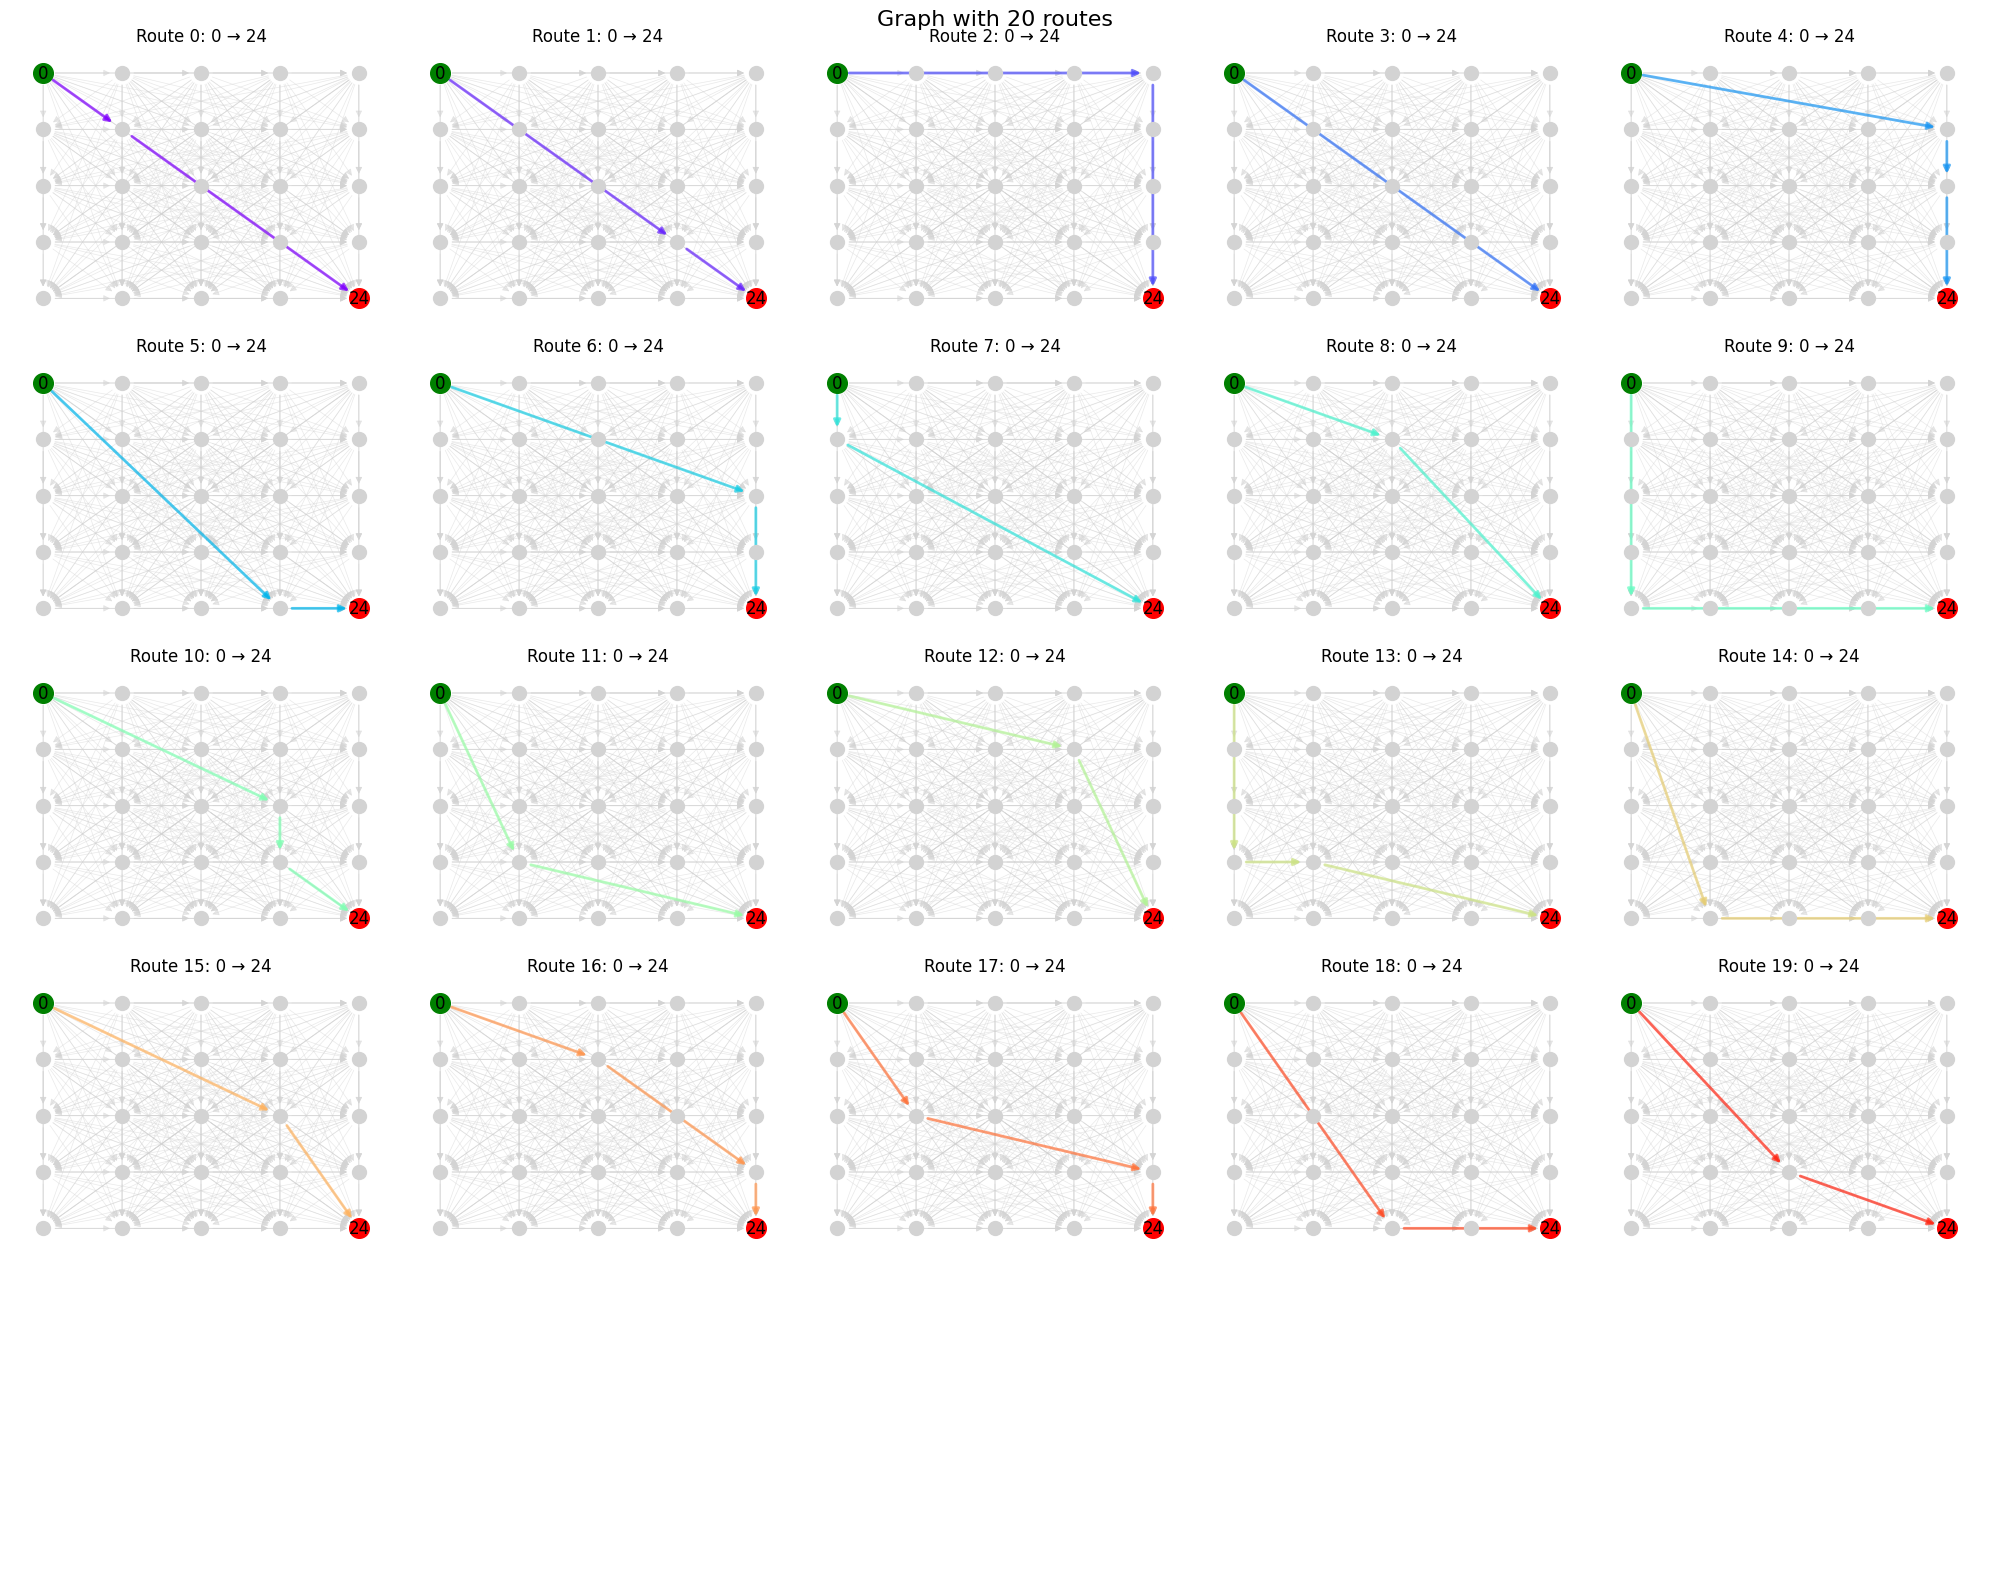

In [6]:
plot_routes(G, routes_0_24)
plt.show()


In [7]:
routes_0_24_final = [routes_0_24[x] for x in [0, 1, 6, 8, 9, 10, 15, 18]]
# Create a random probability distribution for the routes
probabilities = np.random.rand(len(routes_0_24_final))

# Normalize the probabilities to sum to 1
routes_0_24_final_prob = [p / sum(probabilities) for p in probabilities]

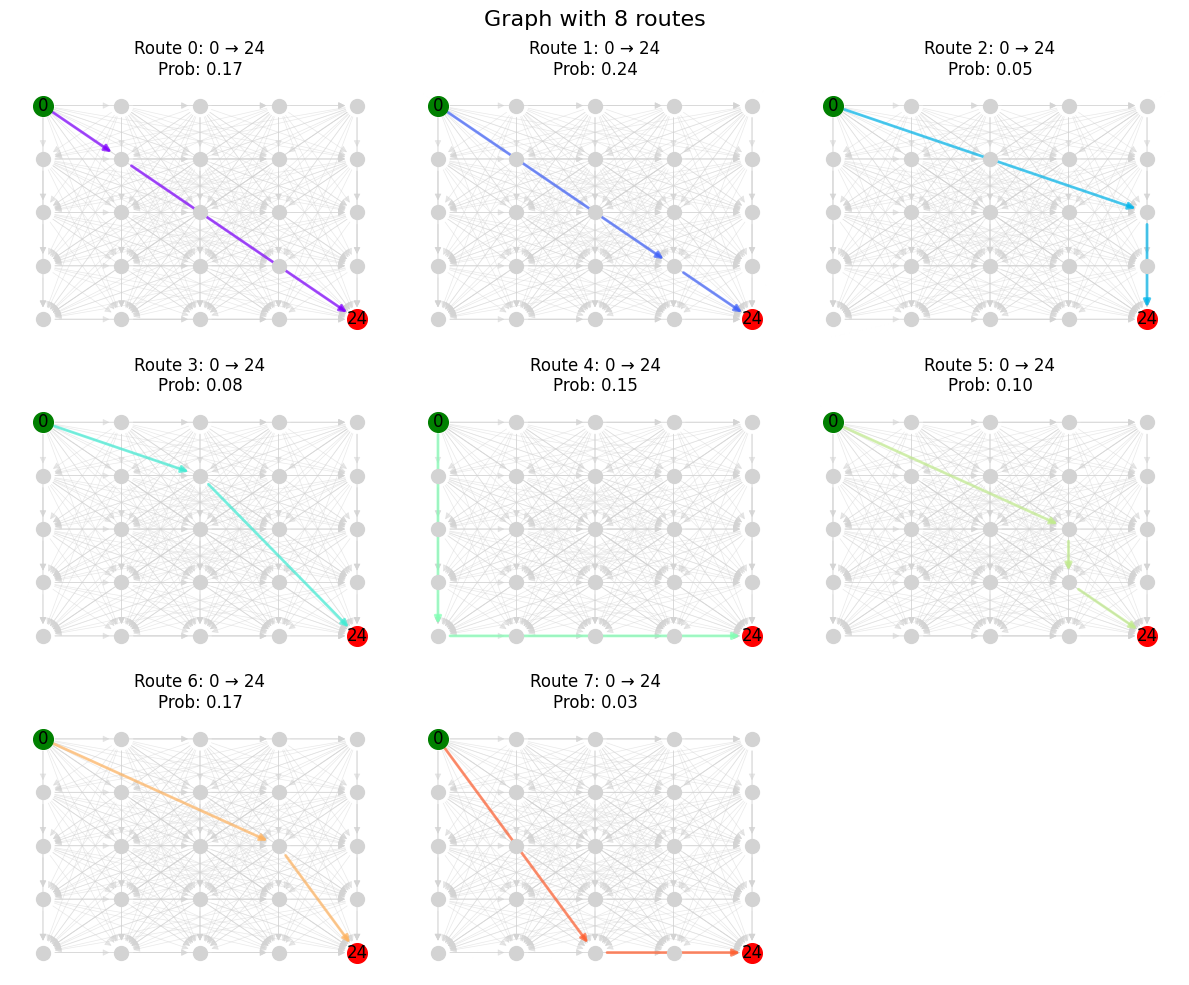

In [8]:
plot_routes(G, routes_0_24_final, probabilities=routes_0_24_final_prob)
plt.show()

# QUASAR-R-Zero Learning Process

In [9]:
from dotenv import load_dotenv
load_dotenv()

import os 

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
# Add PROJECT_ROOT to Python search path 

import sys 
sys.path.append(PROJECT_ROOT)

In [10]:
import lateral.planner_pivot_with_heuristics_lean_fix1000 as mcmc
MAX_ITER = 50_000
BURN_IN = 5_000 # can go as high as 10_000
THINNING = 50 # can go as high as 50 
sampled_routes = []
temperature = 10.0

total_accepted = 0

# Find the shortest path between 0 and 24
# shortest_path = nx.shortest_path(G, source='0', target='24', weight='weight')
shortest_path = ['0', '12', '24']
print(f'Shortest path: {shortest_path}')
route = shortest_path 

import time 
start_time = time.time()
for i in range(MAX_ITER):
    new_route, accepted = mcmc.mcmc_step(G, route, temperature, verbose = False,
                                    max_depth=8, collapse_pivot=False)
    
    print(f'{i < BURN_IN and "Burn-in" or "Sampling"} | Iteration {i+1}, accepted: {total_accepted}               ', end='\r')
    
    if accepted:
        route = new_route
        
    if i > BURN_IN: # Sampling phase
        if accepted:
            total_accepted += 1
        if i % THINNING == 0:
            sampled_routes.append(route)
        
print(f"Total chain time: {time.time() - start_time:.2f} seconds. Total accepted: {total_accepted}/{MAX_ITER - BURN_IN}")


Shortest path: ['0', '12', '24']
Total chain time: 12.80 seconds. Total accepted: 34045/45000


In [11]:
def routes_to_probability_dict(sampled_routes):
    """
    Convert a list of sampled routes into a dictionary with routes as keys
    and their corresponding probabilities as values.
    
    Args:
        sampled_routes: A list of lists, where each inner list represents a route.
    
    Returns:
        A dictionary mapping each unique route (as a tuple) to its probability.
    """
    # Convert each route (which is a list) to a tuple so it can be used as a dictionary key
    routes_as_tuples = [tuple(route) for route in sampled_routes]
    
    # Count occurrences of each route
    route_counts = {}
    for route in routes_as_tuples:
        route_counts[route] = route_counts.get(route, 0) + 1
    
    # Calculate total number of samples
    total_samples = len(sampled_routes)
    
    # Calculate probability for each unique route
    route_probabilities = {route: count / total_samples for route, count in route_counts.items()}
    
    return route_probabilities

route_probs = routes_to_probability_dict(sampled_routes)
for route, prob in route_probs.items():
    print(f"Route {route}: Probability {prob:.2f}")
    

Route ('0', '13', '24'): Probability 0.08
Route ('0', '18', '24'): Probability 0.08
Route ('0', '6', '24'): Probability 0.07
Route ('0', '23', '24'): Probability 0.05
Route ('0', '21', '24'): Probability 0.02
Route ('0', '12', '24'): Probability 0.08
Route ('0', '1', '24'): Probability 0.05
Route ('0', '19', '24'): Probability 0.05
Route ('0', '22', '24'): Probability 0.03
Route ('0', '3', '24'): Probability 0.02
Route ('0', '16', '24'): Probability 0.05
Route ('0', '15', '24'): Probability 0.02
Route ('0', '14', '24'): Probability 0.03
Route ('0', '17', '24'): Probability 0.05
Route ('0', '4', '24'): Probability 0.01
Route ('0', '7', '24'): Probability 0.07
Route ('0', '11', '24'): Probability 0.06
Route ('0', '5', '24'): Probability 0.05
Route ('0', '8', '24'): Probability 0.03
Route ('0', '2', '24'): Probability 0.05
Route ('0', '10', '24'): Probability 0.04
Route ('0', '9', '24'): Probability 0.02
Route ('0', '20', '24'): Probability 0.01


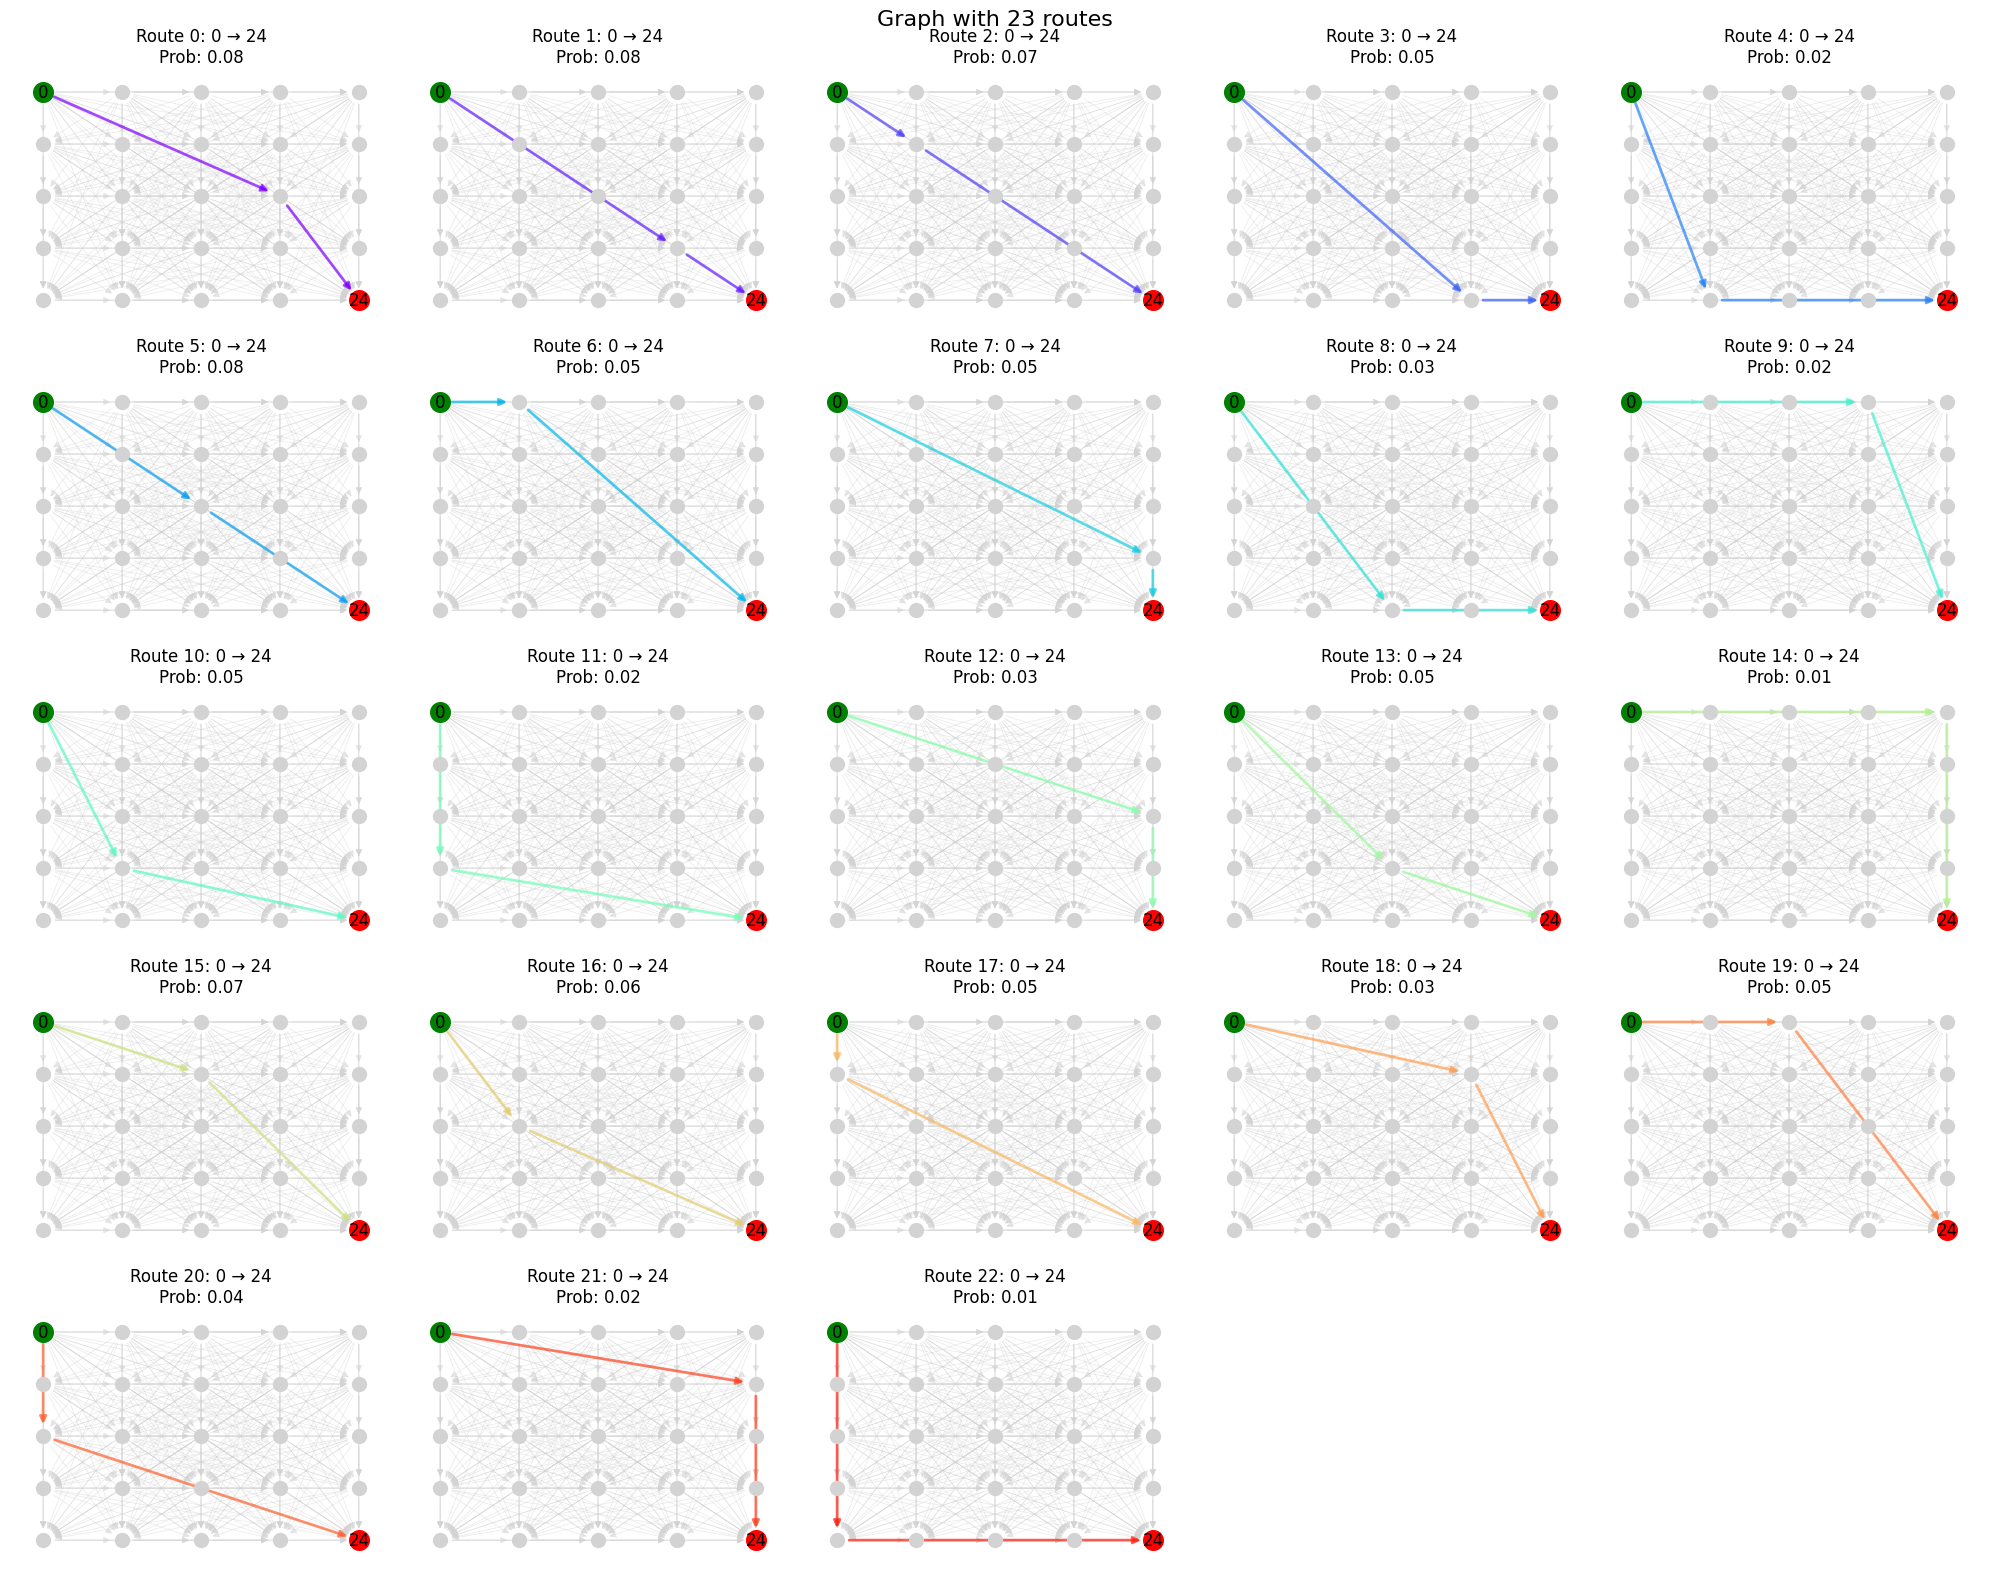

In [12]:
# Convert the dictionary keys from tuples back to lists for plotting
routes_list = [list(route) for route in route_probs.keys()]
probabilities_list = list(route_probs.values())

# Plot the routes with their probabilities
plot_routes(G, routes_list, probabilities=probabilities_list)
plt.show()



# Learning the Preference

Suppose $D(e) = d(e) + w_\rho \rho + w_r \|\rho\|^2$. Clearly the derivative of $c_\rho = (w_\rho + w_r \rho(e_i)) [N(e_i) - \bar{N}(e_i) ]$.

In [14]:
N_samples = len(sampled_routes)
print(f'N_samples: {N_samples}')
# Randomly sample from routes_0_24_final with probabilities given by routes_0_24_final_prob
sampled_routes = random.choices(routes_0_24_final, weights=routes_0_24_final_prob, k=N_samples)
print(f'Sampled {len(sampled_routes)} routes from routes_0_24_final')

N_samples: 899
Sampled 899 routes from routes_0_24_final


In [25]:
import networkx as nx
from collections import Counter
from typing import List, Dict, Tuple, Any, Union

# Define type aliases for clarity
Node = Union[int, str]  # Assuming nodes are ints or strings
Route = List[Node]
Edge = Tuple[Node, Node]
EdgeCounts = Counter[Edge]

def _get_edge_tuple(u: Node, v: Node, directed: bool = True) -> Edge:
    """
    Creates a canonical edge tuple.
    For directed graphs: (u, v)
    For undirected graphs: (min(u, v), max(u, v))
    """
    if directed:
        return (u, v)
    else:
        # Ensure consistent ordering for undirected edges
        return tuple(sorted((u, v)))

def count_edge_traversals(routes: List[Route], directed: bool = True) -> EdgeCounts:
    """
    Counts the number of times each edge is traversed in a list of routes.

    Args:
        routes: A list of routes, where each route is a list of node IDs.
        directed: Whether the graph should be treated as directed (True)
                  or undirected (False) for counting edges.

    Returns:
        A collections.Counter mapping edge tuples to their traversal counts.
    """
    edge_counts: EdgeCounts = Counter()
    for route in routes:
        # A route needs at least 2 nodes to have an edge
        if len(route) < 2:
            continue
        # Iterate through consecutive node pairs to form edges
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            edge = _get_edge_tuple(u, v, directed)
            edge_counts[edge] += 1
    return edge_counts

def update_edge_rho(
    graph: Union[nx.Graph, nx.DiGraph],
    sampled_routes: List[Route],
    routes_0_24_final: List[Route],
    lr: float,
    w_rho: float,
    w_r: float,
    default_rho: float = 0.0,  # Initial rho if not present
    verbose: bool = False
) -> Union[nx.Graph, nx.DiGraph]:
    """
    Updates the 'rho' property of each edge in the graph based on route counts.

    The update follows the formula:
    rho_edge = rho_edge + lr * (w_rho + w_r * rho_edge) *
               (final_count - sampled_count) / total_graph_edges

    Args:
        graph: The NetworkX graph object (Graph or DiGraph).
               Edges are expected to have a 'rho' attribute (or it will be added).
        sampled_routes: List of routes from sampling.
        routes_0_24_final: List of routes from the final set.
        lr: Learning rate.
        w_rho: Weight factor for the constant term in the update.
        w_r: Weight factor for the current rho term in the update.
        default_rho: The default value to assume for rho if an edge doesn't
                     have it yet.

    Returns:
        The graph with updated 'rho' attributes on its edges.
    """
    is_directed = isinstance(graph, nx.DiGraph)

    # Step 1 & 2: Count edge traversals efficiently
    if verbose:
        print("Counting traversals for sampled routes...")
    sampled_counts = count_edge_traversals(sampled_routes, directed=is_directed)
    if verbose:
        print(f"Found {len(sampled_counts)} unique edges traversed in sampled routes.")

    if verbose:
        print("Counting traversals for final routes...")
    final_counts = count_edge_traversals(routes_0_24_final, directed=is_directed)
    if verbose:
        print(f"Found {len(final_counts)} unique edges traversed in final routes.")

    # Step 3: Get total number of edges in the graph for normalization
    total_graph_edges = graph.number_of_edges()
    if total_graph_edges == 0:
        if verbose:
            print("Warning: Graph has no edges. No rho values will be updated.")
        return graph # Nothing to update

    if verbose:
        print(f"Total edges in graph structure: {total_graph_edges}")

    # Step 4: Update rho for each edge in the graph
    if verbose:
        print("Updating rho values for graph edges...")
    updated_count = 0
    for u, v, edge_data in graph.edges(data=True):
        # Get current rho, using default if not present
        current_rho = edge_data.get('rho', default_rho)

        # Determine the edge tuple representation used for counting
        edge_key = _get_edge_tuple(u, v, directed=is_directed)

        # Get counts for this specific edge from the counters
        sampled_edge_count = sampled_counts.get(edge_key, 0)
        final_edge_count = final_counts.get(edge_key, 0)

        # Calculate the difference in counts
        count_diff = final_edge_count - sampled_edge_count

        # Calculate the update amount (delta_rho)
        # Avoid division by zero checked earlier
        update_factor = lr * (w_rho + w_r * current_rho)
        delta_rho = update_factor * count_diff / total_graph_edges

        # Apply the update
        new_rho = current_rho + delta_rho
        
        # print(f"Updated rho for edge {edge_key}: {current_rho:.4f} -> {new_rho:.4f}")
        

        # Store the updated rho back into the graph edge data
        # graph.edges[u, v]['rho'] = new_rho # Preferred way in newer NetworkX
        edge_data['rho'] = new_rho # Also works and modifies in-place
        updated_count += 1

    if verbose:
        print(f"Updated rho for {updated_count} edges.")
    return graph

In [31]:
import lateral.planner_pivot_with_heuristics_lean_fix1000 as mcmc

def sample_from_graph(G, MAX_ITER: int, BURN_IN: int, THINNING: int, temperature: float, verbose: bool = False):
    sampled_routes = []

    total_accepted = 0

    # Find the shortest path between 0 and 24
    shortest_path = nx.shortest_path(G, source='0', target='24', weight='weight')
    # shortest_path = ['0', '12', '24']
    route = shortest_path 

    import time 
    start_time = time.time()
    for i in range(MAX_ITER):
        new_route, accepted = mcmc.mcmc_step(G, route, temperature, verbose = False,
                                        max_depth=8, collapse_pivot=False)
        
        if verbose:
            print(f'{i < BURN_IN and "Burn-in" or "Sampling"} | Iteration {i+1}, accepted: {total_accepted}               ', end='\r')
        
        if accepted:
            route = new_route
            
        if i > BURN_IN: # Sampling phase
            if accepted:
                total_accepted += 1
            if i % THINNING == 0:
                sampled_routes.append(route)

    if verbose:
        print(f"Total chain time: {time.time() - start_time:.2f} seconds. Total accepted: {total_accepted}/{MAX_ITER - BURN_IN}")
        
    return sampled_routes

In [32]:
learning_rate = 0.1
weight_rho = 1.0
weight_r = 0.5
initial_rho = 0.0
MAX_ITER = 50_000
BURN_IN = 5_000
THINNING = 50
temperature = 10.0

learning_steps = 100

GX = G.copy()
# Initialize rho property for each edge to zero
for u, v, data in GX.edges(data=True):
    data['rho'] = 0.0
    
print(f"Added 'rho' property initialized to 0.0 for all {len(GX.edges())} edges in the graph.")

from tqdm import tqdm
for iter in tqdm(range(learning_steps)):
    # Sample routes from the current graph
    sampled_routes = sample_from_graph(GX, MAX_ITER, BURN_IN, THINNING, temperature, False)
    
    GX = update_edge_rho(
        GX,
        sampled_routes,
        routes_0_24_final,
        learning_rate,
        weight_rho,
        weight_r,
        default_rho=initial_rho # Pass the initial default
    )
    

Added 'rho' property initialized to 0.0 for all 300 edges in the graph.


  5%|▌         | 5/100 [06:20<2:00:23, 76.03s/it]


KeyboardInterrupt: 

In [24]:
G_updated